# Самойлович Константин Поток 15-10-2021 Промежуточный проект

# Проект e-commerce: вариант 1 

In [1]:
# Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

# 1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

# 3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
#     Не стоит забывать, что внутри месяца может быть не целое количество недель. 
#     Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

# 5. Напиши функцию на python, позволяющую строить когортный анализ.
#     В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц.
#     Описание подхода можно найти тут. (10 баллов)

# 6. Построй RFM-кластеры для пользователей. 
#     Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M).
#     Описание подхода можно найти тут. (35 баллов)

# Загрузка данных и их первичная обработка

In [5]:
import pandas as pd
import numpy as np
from datetime import date,timedelta
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
%matplotlib inline
import matplotlib

In [2]:
# Файлы:

#  olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
# customer_id — позаказный идентификатор пользователя (аналог номера паспорта)

# customer_unique_id —  уникальный идентификатор пользователя

# customer_zip_code_prefix —  почтовый индекс пользователя

# customer_city —  город доставки пользователя

# customer_state —  штат доставки пользователя

In [6]:
df_customer_data = pd.read_csv('/home/jupyter-k-samojlovich-17/Python/Intermediate_Project/olist_customers_dataset.csv')

In [4]:
df_customer_data.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [5]:
# olist_orders_dataset.csv —  таблица заказов
# order_id —  уникальный идентификатор заказа (номер чека)

# customer_id —  позаказный идентификатор пользователя (аналог номера паспорта)

# order_status —  статус заказа

# order_purchase_timestamp —  время создания заказа

# order_approved_at —  время подтверждения оплаты заказа

# order_delivered_carrier_date —  время передачи заказа в логистическую службу

# order_delivered_customer_date —  время доставки заказа

# order_estimated_delivery_date —  обещанная дата доставки

In [8]:
df_orders = pd.read_csv('/home/jupyter-k-samojlovich-17/Python/Intermediate_Project/olist_orders_dataset.csv'\
                        , parse_dates=['order_purchase_timestamp'\
                                     , 'order_approved_at'\
                                     , 'order_delivered_carrier_date'\
                                     , 'order_delivered_customer_date'\
                                     , 'order_estimated_delivery_date'\
                                     ])

In [9]:
df_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04


In [8]:
# order_status —  статус заказа
# created —  создан
# approved —  подтверждён
# invoiced —  выставлен счёт
# processing —  в процессе сборки заказа
# shipped —  отгружен со склада
# delivered —  доставлен пользователю
# unavailable —  недоступен
# canceled —  отменён

In [9]:
# olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

# order_id —  уникальный идентификатор заказа (номер чека)
# order_item_id —  идентификатор товара внутри одного заказа
# product_id —  ид товара (аналог штрихкода)
# seller_id — ид производителя товара
# shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
# price —  цена за единицу товара
# freight_value —  вес товара

# — Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

In [10]:
df_orders_items = pd.read_csv('/home/jupyter-k-samojlovich-17/Python/Intermediate_Project/olist_order_items_dataset.csv')

In [11]:
df_orders_items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [12]:
df_customer_data.isna().sum() # проверка на пустые значения (пропуски)

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [13]:
df_customer_data.duplicated().sum() # проверка на дублирование

0

In [14]:
df_customer_data.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [15]:
df_customer_data.shape

(99441, 5)

In [16]:
df_orders.isna().sum() # ЕСТЬ ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ !!! 

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [17]:
df_orders.duplicated().sum() # проверка на дублирование

0

In [18]:
df_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [19]:
df_orders.shape

(99441, 8)

In [20]:
df_orders_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [21]:
df_orders_items.duplicated().sum() # проверка на дублирование

0

In [22]:
df_orders_items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [23]:
df_orders_items.shape

(112650, 7)

# Задание №1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов)

In [30]:
# Объединяем 2 первые таблицы

In [11]:
df_12 = df_customer_data.merge(df_orders, how='inner', on='customer_id')

In [12]:
df_12.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06


In [33]:
# совершили покупку, т.е. не просто заказали товар, но и купили(оплатили) его. Значит, статус заказа должен быть "оплачен",
# но такого нет.Наиболее подходящий - delivered (доставлен пользователю)

In [118]:
df_12_deliv = df_12.query('order_status == "delivered"') # заказы со статусом delivered (доставлен пользователю)

In [119]:
df_12_deliv.shape

(96478, 12)

In [120]:
df_12_deliv.groupby('customer_unique_id', as_index=False).agg({'order_status': 'count'}).query('order_status == 1')

,customer_unique_id,order_status
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,1
93354,fffea47cd6d3cc0a88bd621562a9d061,1
93355,ffff371b4d645b6ecea244b27531430a,1
93356,ffff5962728ec6157033ef9805bacc48,1


In [37]:
# ОТВЕТ: 90557 пользователей, которые совершили покупку только один раз

# Задание №2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

In [122]:
# заказы, которые не доставлены, это заказы со статусом, отличным от delivered (доставлен пользователю):
df_12_not_deliv = df_12.query('order_status != "delivered"')

In [123]:
df_12_not_deliv

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
46,f34a6e874087ec1f0e3dab9fdf659c5d,233896de79986082f1f479f1f85281cb,38300,ituiutaba,MG,6e98de3a85c84ead6689189b825d35b5,canceled,2018-03-15 10:07:02,2018-03-15 10:29:33,NaT,NaT,2018-04-09
47,c132855c926907970dcf6f2bf0b33a24,a8ae36a2bb6c2bbc3b5d62ede131c9ef,18740,taquarituba,SP,b5172d4a722c0ebb34c29bbbb7a3cb42,invoiced,2018-04-17 13:14:13,2018-04-18 05:31:51,NaT,NaT,2018-05-24
70,4c7241af24b5344cb01fe687643de4fe,b157c176c3fe04914fde33f2dc8b878a,60336,fortaleza,CE,ad380680e87dea0f2abf5cd5bace626c,shipped,2018-01-21 15:54:02,2018-01-22 13:52:41,2018-01-24 18:26:40,NaT,2018-02-20
79,f6529ffebe6b3440d45d89604a4239ac,e5dbefdfdf3eff75c8e6cd655f128279,26272,nova iguacu,RJ,cc07a8fdd3a8e94d683c8142a117dbc1,shipped,2018-01-11 17:11:11,2018-01-12 17:49:45,2018-01-17 16:56:32,NaT,2018-02-09
100,ae76a4650235ab18764708174f1da31e,2b6082a140c439e2df870c85b0aa5e88,2983,sao paulo,SP,4c33ec562d9dc5655e160913aa86eb53,shipped,2017-08-11 23:47:48,2017-08-12 00:03:51,2017-08-14 13:24:58,NaT,2017-09-11
...,...,...,...,...,...,...,...,...,...,...,...,...
99248,6a65b5d6d4f4c9dfda93798cf014ee47,5b66137675c164a7df3b639bf1e86134,3959,sao paulo,SP,8c0dd54ff6a273a02de12494c6bf299f,shipped,2018-07-17 22:35:46,2018-07-18 21:22:25,2018-07-30 09:00:00,NaT,2018-08-02
99280,9ce70b8dafe76524f3d5e5e68cbf29f5,6edd9e4a22b7ab02db2a87f13bfd2d2a,14093,ribeirao preto,SP,e5e59fe47003046e2ed48ebb641564b2,shipped,2018-04-27 13:52:12,2018-04-27 14:09:00,2018-05-02 14:39:00,NaT,2018-05-23
99288,2a6fc1968c4a29c9c258bb1994afbc7f,205a1c797b2c6e626d560900a3ebde6b,27210,volta redonda,RJ,12d9fe1a3efa51a7fae337cba819adc1,shipped,2017-02-08 13:07:19,2017-02-09 02:50:42,2017-02-09 10:56:46,NaT,2017-03-17
99351,f83083fcbc51d12f8279b5713c2d4b4d,0465f164e35aba70f70e911b252513a9,77807,araguaina,TO,67384817c871ae183b24f9a0a6eb9bbc,shipped,2018-01-25 12:12:37,2018-01-25 12:31:27,2018-01-26 17:49:00,NaT,2018-03-01


In [124]:
# ОПРЕДЕЛИМ ЧИСЛО МЕСЯЦЕВ В ПРЕДСТАВЛЕННЫХ ДАННЫХ

In [125]:
# сортируем по дате доставки заказа
df_12_2 = df_12_not_deliv.sort_values('order_estimated_delivery_date')

In [126]:
time_start = df_12_2.order_purchase_timestamp.iloc[0] # дата и время первого заказа

In [127]:
time_finish = df_12_2.order_purchase_timestamp.iloc[-1] # дата и время последнего заказа

In [128]:
time_interval = time_finish - time_start # интервал времени между последним и первым заказом

In [129]:
# среднее количество количество дней в месяце
month_avr = 365 / 12
month_avr

30.416666666666668

In [130]:
# среднее количество месяцев в датафрейме
time_month = round(time_interval.days / month_avr, 2)
time_month

25.08

In [131]:
df_status = df_12_not_deliv.groupby('order_status', as_index=False)\
                           .agg({'customer_unique_id': 'count'})\
                           .rename(columns={'customer_unique_id': 'number'})

In [132]:
# Добавляю столбец - среднее в месяц количество заказов, не доставляенных по разным причинам avg_not_deliv
df_status['avg_not_deliv'] = (df_status.number / time_month).round(2)

In [133]:
df_status

,order_status,number,avg_not_deliv
0,approved,2,0.08
1,canceled,625,24.92
2,created,5,0.20
3,invoiced,314,12.52
4,processing,301,12.00
5,shipped,1107,44.14
6,unavailable,609,24.28


In [134]:
# ОТВЕТ:
df_status[['order_status', 'avg_not_deliv']]

,order_status,avg_not_deliv
0,approved,0.08
1,canceled,24.92
2,created,0.20
3,invoiced,12.52
4,processing,12.00
5,shipped,44.14
6,unavailable,24.28


In [51]:
# Примечание: Возможно, некоторые заказы находятся в стадии оформления, сборки или транспортировки и будут
#             доставлены закзчику в будущем (но,могут и не быть доставлены - что-то пошло не так).
#             Так как задача провести анализ на соблюдение обещанной даты поставки на данном этапе не ставилась,
#             считаю полученный ответ достаточным.

# Задание №3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

In [52]:
# Объединяем 2 и 3 таблицы

In [108]:
df_23 = df_orders_items.merge(df_orders, how='left', on='order_id')

In [109]:
df_23

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25


In [110]:
df_23['order_day_of_week'] = df_23['order_purchase_timestamp'].dt.day_name()

In [111]:
df_23

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_day_of_week
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,Wednesday
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,Sunday
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,Wednesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,Monday
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,Saturday
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,Monday
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,Monday


In [140]:
df_product_day = df_23.groupby(['product_id', 'order_day_of_week'], as_index=False)\
                .agg({'order_id': 'count'}).rename(columns={'order_id': 'order_count'})

In [141]:
df_product_day

,product_id,order_day_of_week,order_count
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
61225,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
61226,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1
61227,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
61228,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2


In [142]:
df_product_day_tab = df_product_day.pivot_table(index='product_id',
             columns='order_day_of_week',
             values='order_count',
             fill_value=0)

In [143]:
df_product_day_tab

order_day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
product_id,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,0,0,0,1,0,0,0
00088930e925c41fd95ebfe695fd2655,0,0,0,0,0,1,0
0009406fd7479715e4bef61dd91f2462,0,0,0,0,1,0,0
000b8f95fcb9e0096488278317764d19,1,0,0,0,0,0,1
000d9be29b5207b54e86aa1b1ac54872,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
fff6177642830a9a94a0f2cba5e476d1,0,0,1,1,0,0,0
fff81cc3158d2725c0655ab9ba0f712c,0,1,0,0,0,0,0
fff9553ac224cec9d15d49f5a263411f,1,0,0,0,0,0,0


In [145]:
df_product_day_tab['max_day'] = df_product_day_tab.idxmax(axis=1)

In [146]:
df_product_day_tab

order_day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,max_day
product_id,,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,0,0,0,1,0,0,0,Sunday
00088930e925c41fd95ebfe695fd2655,0,0,0,0,0,1,0,Tuesday
0009406fd7479715e4bef61dd91f2462,0,0,0,0,1,0,0,Thursday
000b8f95fcb9e0096488278317764d19,1,0,0,0,0,0,1,Friday
000d9be29b5207b54e86aa1b1ac54872,0,0,0,0,0,1,0,Tuesday
...,...,...,...,...,...,...,...,...
fff6177642830a9a94a0f2cba5e476d1,0,0,1,1,0,0,0,Saturday
fff81cc3158d2725c0655ab9ba0f712c,0,1,0,0,0,0,0,Monday
fff9553ac224cec9d15d49f5a263411f,1,0,0,0,0,0,0,Friday


# Задание №4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?
Не стоит забывать, что внутри месяца может быть не целое количество недель. 
Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

In [ ]:
# Фактом совершения покупки пользователем считаем завершенное действие в виде получения
# заказанного товара пользователем (доставленные заказы)

In [135]:
# доставленные заказы, файл сформирован в задании №1
df_12_deliv

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05


In [136]:
df_12_deliv['Date'] = df_12_deliv.order_delivered_customer_date\
                                         .apply(lambda x: x.replace(day=1, hour=0, minute=0, second=0, microsecond=0))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [137]:
df_12_deliv

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,Date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05-01
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-06-01
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03-01
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,2018-04-01
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,2018-04-01
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,2018-05-01
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,2017-11-01


In [138]:
df_12_month = df_12_deliv.groupby(['customer_unique_id', 'Date'], as_index=False)\
           .agg({'customer_state': 'count'})\
           .rename(columns={'customer_state': 'custom_count'}).sort_values('Date')

In [139]:
df_12_month

,customer_unique_id,Date,custom_count
92255,f79fe58e24e35fe4c036e1fb462769de,2016-10-01,1
30617,522e714643e682c9eff7415cffae54fb,2016-10-01,1
2296,0636d30c77f0f9cfad81f1c9b58c791f,2016-10-01,1
30354,517a3d8518447c776efd430b66470e27,2016-10-01,1
45474,7a176e5d88c7acb6000a055e008c055d,2016-10-01,2
...,...,...,...
92382,f7f8503e3befafa49f5dd00928dc0dd6,2018-09-01,1
92859,f942774febec601b810cb1987bcb46da,2018-09-01,1
93857,fc0bcca3d8d90a812b707bb8e45069d6,2018-10-01,1
28213,4bc530761c1b59d33d7c6cb640d3ee78,2018-10-01,1


In [140]:
df_12_month_2 = df_12_month.pivot_table(index='customer_unique_id', columns='Date', values='custom_count', fill_value=0)

In [141]:
df_12_month_2

Date,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,...,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0000f46a3911fa3c0805444483337064,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
fffea47cd6d3cc0a88bd621562a9d061,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
ffff371b4d645b6ecea244b27531430a,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
# Расчитаем среднее количество недель в месяце (у нас один 2016 год високосный, но февраля в данных нет )

In [143]:
d_31 = 31 / 4 # месяцы, в которых 31 день

In [144]:
d_28 = 28 / 4 # месяц, в котором 28 дней

In [145]:
d_30 = 30 / 4 # месяцы, в которых 30 дней

In [146]:
df_12_month_2.columns

DatetimeIndex(['2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [147]:
# среднее в неделю количество заказов для месяцев, в которых 31 день
df_12_month_2[['2016-10-01',  '2016-12-01', '2017-01-01', '2017-03-01', '2017-05-01',\
                '2017-07-01', '2017-08-01', '2017-10-01', '2017-12-01', '2018-01-01',\
                '2018-03-01',  '2018-05-01','2018-07-01', '2018-08-01', '2018-10-01']]\
= df_12_month_2[['2016-10-01',  '2016-12-01', '2017-01-01', '2017-03-01', '2017-05-01',\
                '2017-07-01', '2017-08-01', '2017-10-01', '2017-12-01', '2018-01-01',\
                '2018-03-01',  '2018-05-01','2018-07-01', '2018-08-01', '2018-10-01']] / d_31

In [148]:
# среднее в неделю количество заказов для месяцев, в которых 30 дней
df_12_month_2[['2016-11-01', '2017-04-01', '2017-06-01', '2017-09-01',\
               '2017-11-01', '2018-04-01', '2018-06-01', '2018-09-01']]\
= df_12_month_2[['2016-11-01', '2017-04-01', '2017-06-01', '2017-09-01',\
               '2017-11-01', '2018-04-01', '2018-06-01', '2018-09-01']] / d_30

In [151]:
# среднее в неделю количество заказов для месяцев, в которых 28 дней
df_12_month_2[['2017-02-01', '2018-02-01']]\
= df_12_month_2[['2017-02-01', '2018-02-01']] / d_28

In [153]:
# ИТОГОВАЯ ТАБЛИЦА - Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)
df_12_month_2

Date,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,...,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.129032,0.0,0.0,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.129032,0.0,0.0,0.0,0.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.000000,0.0,0.133333,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.129032,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.129032,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
ffff371b4d645b6ecea244b27531430a,0.0,0.0,0.0,0.0,0.020408,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


# Задание 5. Напиши функцию на python, позволяющую строить когортный анализ. 
           В период с января по декабрь выяви когорту с самым высоким retention на 3-й месяц. (10 баллов)

In [13]:
df_12 # файл из задания №1 (объединены 1 и 2 таблицы)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05


In [14]:
df_55 = df_12[['customer_unique_id', 'order_id', 'order_purchase_timestamp']]

In [30]:
df_55['order_month'] = df_55['order_purchase_timestamp'].dt.to_period('M')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
df_55

,customer_unique_id,order_id,order_purchase_timestamp,order_month,cohort
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01,2018-01
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-05,2018-05
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03,2018-03
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018-07,2018-07
...,...,...,...,...,...
99436,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,2018-04-07 15:48:17,2018-04,2018-04
99437,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,2018-04-04 08:20:22,2018-04,2018-04
99438,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,2018-04-08 20:11:50,2018-04,2018-04
99439,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,2017-11-03 21:08:33,2017-11,2017-11


In [32]:

df_55['cohort'] = df_55.groupby('customer_unique_id')['order_purchase_timestamp'] \
                 .transform('min') \
                 .dt.to_period('M') 

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
df_55

,customer_unique_id,order_id,order_purchase_timestamp,order_month,cohort
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01,2018-01
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-05,2018-05
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03,2018-03
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018-07,2018-07
...,...,...,...,...,...
99436,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,2018-04-07 15:48:17,2018-04,2018-04
99437,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,2018-04-04 08:20:22,2018-04,2018-04
99438,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,2018-04-08 20:11:50,2018-04,2018-04
99439,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,2017-11-03 21:08:33,2017-11,2017-11


In [34]:
df_cohort = df_55.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('customer_unique_id', 'nunique')) \
              .reset_index(drop=False)

In [44]:
df_cohort = df_cohort.query('cohort > "2016-12" and cohort < "2018-01"') # период с полным годом с января по декабрь

In [45]:
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [47]:
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
cohort,,,,,,,,,,,,,,,,,,,
2017-01,764.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0,NaN
2017-03,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,4.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN
2017-04,2352.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN,NaN
2017-05,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,11.0,9.0,12.0,9.0,1.0,7.0,9.0,NaN,NaN,NaN
2017-06,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN
2017-07,3894.0,20.0,14.0,10.0,11.0,8.0,12.0,4.0,7.0,10.0,9.0,12.0,5.0,10.0,NaN,NaN,NaN,NaN,NaN
2017-08,4184.0,29.0,14.0,11.0,15.0,22.0,12.0,11.0,6.0,6.0,10.0,8.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4130.0,28.0,22.0,12.0,19.0,9.0,9.0,10.0,12.0,7.0,11.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Функция для выявления когорты с самым высоким retention на 3-й месяц

In [49]:
def max_cohort_retention (df_name):
    cohort_name = (df_name.iloc[:,3] / df_name.iloc[:,0]).idxmax()
    return cohort_name

In [50]:
# выявляем когорту с самым высоким retention на 3-й месяц
max_cohort_retention (cohort_pivot)

Period('2017-06', 'M')


# Задание №6. Построй RFM-кластеры для пользователей.
Выведи для каждого кластера средние значения метрик R, F, M (и опиши подробно, как были построены метрики R, F, M).(35 баллов)

In [38]:
df_all = df_12.merge(df_orders_items, how='inner', on='order_id') # объединены все 3 исходные датафреймы

In [49]:
orders = df_all[['order_delivered_carrier_date', 'customer_unique_id', 'price']]\
      .rename(columns={'order_delivered_carrier_date': 'order_date', 'customer_unique_id': 'user_id', 'price': 'order_value'})

In [79]:
orders

,order_date,user_id,order_value
0,2017-05-23 10:47:57,861eff4711a542e4b93843c6dd7febb0,124.99
1,2018-01-15 17:14:59,290c77bc529b7ac935b93aa66c333dc3,289.00
2,2018-06-11 14:31:00,060e732b5b29e8181a18229c7b0b2b5e,139.94
3,2018-03-27 23:22:42,259dac757896d24d7702b9acbbff3f3c,149.94
4,2018-07-30 15:16:00,345ecd01c38d18a9036ed96c73b8d066,230.00
...,...,...,...
112645,2018-04-11 02:08:36,1a29b476fee25c95fbafc67c5ac95cf8,74.90
112646,2018-04-05 18:42:35,d52a67c98be1cf6a5c84435bd38d095d,114.90
112647,2018-04-09 17:52:17,e9f50caf99f032f0bf3c55141f019d99,37.00
112648,2017-11-06 18:24:41,73c2643a0a458b49f58cea58833b192e,689.00


In [80]:
last_date = orders['order_date'].max() + timedelta(days=1)

In [81]:
# отбираем и агируем нужные данные из исходного датафрейма
RFM_data = orders.groupby('user_id').agg({'order_date': lambda x: (last_date - x.max()).days,
                                                 'user_id': lambda x: len(x), 
                                                 'order_value': lambda x: x.sum()})

In [82]:
RFM_data.rename(columns={'order_date': 'recency', 
                          'user_id': 'frequency', 
                          'order_value': 'monetary'}, inplace=True)

In [83]:
RFM_data

,recency,frequency,monetary
user_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,123.0,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,126.0,1,18.90
0000f46a3911fa3c0805444483337064,548.0,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,333.0,1,25.99
0004aac84e0df4da2b147fca70cf8255,299.0,1,180.00
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,446.0,2,1570.00
fffea47cd6d3cc0a88bd621562a9d061,265.0,1,64.89
ffff371b4d645b6ecea244b27531430a,581.0,1,89.90


In [ ]:
# RFM-кластеры для пользователей
# Описание: Каждого клиента базы данных за исследуемый период распределяем по соответствующим сегментам.
#           Для этого групы recency, frequency и monetary разобьем на 5 категорий, и каждому пользователю 
#           выставим соответстующую оценку от 1 до 5 в каждой группе с помощью нижеследующего скрипта:            

In [88]:
quantiles = RFM_data.quantile(q=[0.20, 0.40, 0.60, 0.80])
quantiles = quantiles.to_dict()
segmented_rfm = RFM_data

def RScore(x,p,d):
     if x <= d[p][0.20]:
         return 1
     elif x <= d[p][0.40]:
         return 2
     elif x <= d[p][0.60]: 
         return 3
     elif x<=d[p][0.80]:
         return 4
     else:
         return 5

segmented_rfm['R_grade'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['F_grade'] = segmented_rfm['frequency'].apply(RScore, args=('frequency',quantiles,))
segmented_rfm['M_grade'] = segmented_rfm['monetary'].apply(RScore, args=('monetary',quantiles,))
segmented_rfm['RFM_grade'] = segmented_rfm.R_grade.map(str) + segmented_rfm.F_grade.map(str) + segmented_rfm.M_grade.map(str)
segmented_rfm['RFM_mean'] = (segmented_rfm.R_grade + segmented_rfm.F_grade + segmented_rfm.M_grade) / 3
#print(segmented_rfm.head())
RFM_all = segmented_rfm[['r_grade', 'f_grade', 'm_grade',
       'RFM_grade', 'RFM_mean']]

In [91]:
RFM_all # итоговый файл с RFM-разделением и средним для кластера значением RFM-метрик

,r_grade,f_grade,m_grade,RFM_grade,RFM_mean
user_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2,1,4,214,2.333333
0000b849f77a49e4a4ce2b2a4ca5be3f,2,1,1,211,1.333333
0000f46a3911fa3c0805444483337064,5,1,2,512,2.666667
0000f6ccb0745a6a4b88665a16c9f078,4,1,1,411,2.000000
0004aac84e0df4da2b147fca70cf8255,4,1,5,415,3.333333
...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,5,5,5,555,5.000000
fffea47cd6d3cc0a88bd621562a9d061,3,1,2,312,2.000000
ffff371b4d645b6ecea244b27531430a,5,1,3,513,3.000000


In [92]:
# Рассортируем пользователей по кластерам
RFM_all.sort_values('RFM_mean')

,r_grade,f_grade,m_grade,RFM_grade,RFM_mean
user_id,,,,,
2da2a01f3b907a9754a2ff4a8e999fc7,1,1,1,111,1.0
c82677c0f4ba35f3e3a928f38de5cab2,1,1,1,111,1.0
dcd5b4583ea40a6ea31c583e964e7046,1,1,1,111,1.0
e5c973ac8c8276b130a8b02e85df6ec6,1,1,1,111,1.0
561c55720d6ad810863839fea8f32329,1,1,1,111,1.0
...,...,...,...,...,...
50a662e7d7e7e2a94112a4f15a37464e,5,5,5,555,5.0
16f418beb2b081f72be09d327efaf4a9,5,5,5,555,5.0
cb7b0a31f4d257be90adf28f7a0afc47,5,5,5,555,5.0


In [94]:
# Можно фильтровать пользователей по кластерам, например
RFM_all.sort_values('RFM_mean').query('RFM_grade == "214"')

,r_grade,f_grade,m_grade,RFM_grade,RFM_mean
user_id,,,,,
984f54c98f761d6af37e70305a09044a,2,1,4,214,2.333333
7019c99575147f8ea1bbf0a6e281bbf9,2,1,4,214,2.333333
989eb11e93f4f19765421ce152413bbc,2,1,4,214,2.333333
989d76487f04e6534d02ef3fb5ed0863,2,1,4,214,2.333333
b98ab146a7182273ff26de43f0cea7fc,2,1,4,214,2.333333
...,...,...,...,...,...
49910372b68e54a7d85f83ab77637810,2,1,4,214,2.333333
6776ae9432a76cace1d54a6fd1abcc57,2,1,4,214,2.333333
d02922ed8b104d4596ca4bd3770c763e,2,1,4,214,2.333333


In [ ]:
Интерпретация примера: 
    R - recency — давность F - frequency — частота M - monetary — деньги (общая сумма покупок)
В кластер "214" попадают пользователи, которые 2 - довольно давно покупали 1 - редко покупали 4 - на относительно крупную сумму
Их можно попытаться вернуть, сделав им коммерческое предложение

# ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ

# ПОКАЗАТЕЛЬ 'recency'

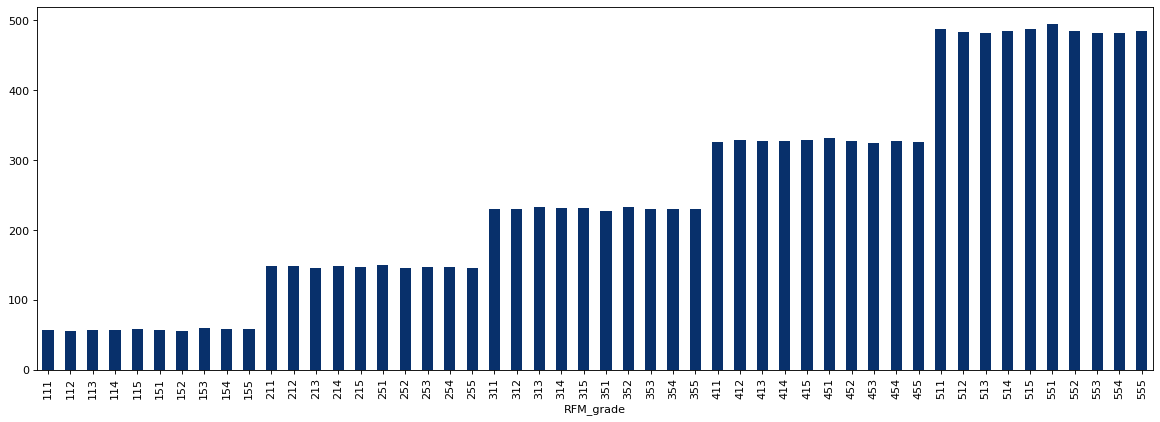

In [114]:
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
segmented_rfm.groupby('RFM_grade').agg('recency').mean().plot(kind='bar', colormap='Blues_r')
plt.show()

# ПОКАЗАТЕЛЬ 'frequency'

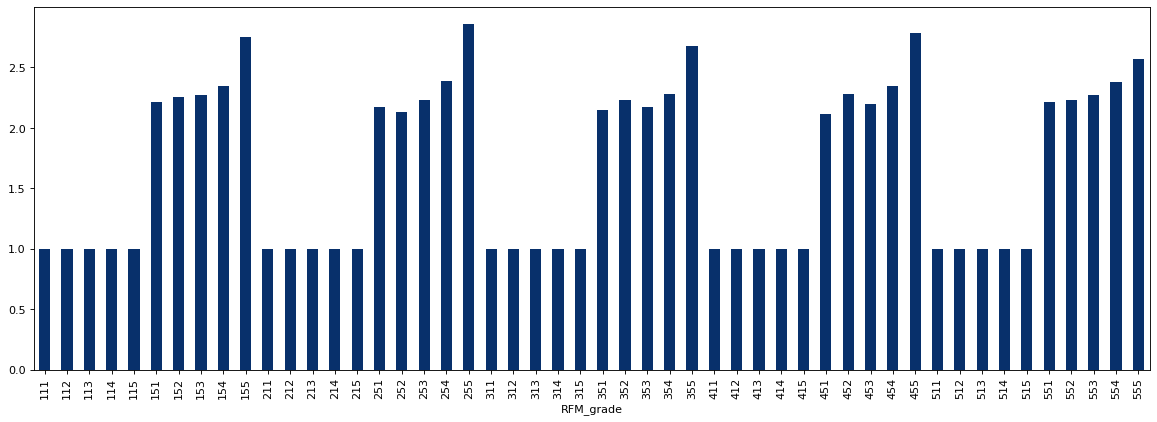

In [116]:
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
segmented_rfm.groupby('RFM_grade').agg('frequency').mean().plot(kind='bar', colormap='Blues_r')
plt.show()

# ПОКАЗАТЕЛЬ 'monetary'

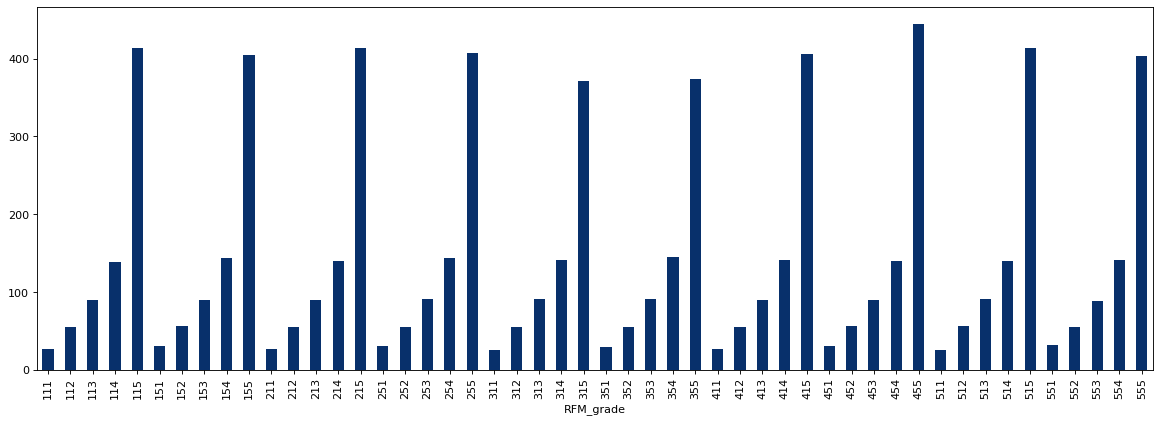

In [109]:
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
segmented_rfm.groupby('RFM_grade').agg('monetary').mean().plot(kind='bar', colormap='Blues_r')
plt.show()